In [1]:
!pip install openl3
!pip install tqdm
!pip install av

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openl3: filename=openl3-0.4.2-py2.py3-none-any.whl size=249327030 sha256=3436e7fbdcc53a45de43ccaf9711d3e26b3be504d7453941a2cc1f8e9c20c3e9
  Stored in directory: /root/.cache/pip/wheels/35/e9/4c/b1e39385b21f2b4d70c01b8793ecc921d69f167cc772868abe
  Created wheel for kapre: filename=kapre-0.3.7-py3-none-any.whl size=29642 sha256=a6744b7130214bb0945e7d13858e844ad25d8f61ebd5faf60cb086dc34934799
  Stored in directory: /root/.cache/pip/wheels/d2/17/ce/09b7d799a7c8b463b0a1657941331e0f10112864ff78d28f87
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320705 sha256=b393a449a92115ec76c41a678a5e2f7eda60dafb73e449f56e6cf669a1f3703a
  Stored in directory: /root/

In [2]:
import torch
import torch.nn as nn
import torchvision.models.video as video_models
import openl3
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim
from torchvision.io import read_video
import torchaudio
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Tweaks to fix GPU bugs faced
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
class VideoEncoder(nn.Module):
    def __init__(self, freeze_weights=True):
        super().__init__()
        base_model = video_models.r3d_18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])

        if freeze_weights:
          for param in self.feature_extractor.parameters():
              param.requires_grad = False

    def forward(self, x):  # (B, C, T, H, W)
        x = self.feature_extractor(x)  # (B, 512, 1, 1, 1)
        x = x.view(x.size(0), -1)

        return x

In [12]:
class OpenL3Encoder(nn.Module):
    def __init__(self, input_repr="mel256", content_type="music", embedding_size=512):
        super().__init__()
        self.sr = 48000
        self.model = openl3.models.load_audio_embedding_model(
            input_repr=input_repr,
            content_type=content_type,
            embedding_size=embedding_size
        )
        self.embedding_size = embedding_size

    def forward(self, x):
        embeddings = []

        is_list_input = isinstance(x, list)
        if is_list_input:
            batch_size = len(x)
            if batch_size == 0: # Handle empty list case
                 device = self.proj_head.net[0].weight.device
                 empty_proj_input = torch.empty(0, self.embedding_size).to(device)
                 return self.proj_head(empty_proj_input)
            # Get device from first tensor in list
            device = x[0].device
        elif isinstance(x, torch.Tensor):
            batch_size = x.size(0)
            if batch_size == 0: # Handle empty tensor case
                 device = self.proj_head.net[0].weight.device
                 empty_proj_input = torch.empty(0, self.embedding_size).to(device)
                 return self.proj_head(empty_proj_input)
            device = x.device # Get device from the tensor itself
        else:
            raise TypeError(f"OpenL3Encoder expects input as list or tensor, got {type(x)}")


        # --- Process each audio sample ---
        for i in range(batch_size):
            if is_list_input:
                audio_tensor = x[i] # Get the i-th tensor from the list
            else:
                audio_tensor = x[i, :] # Get the i-th slice from the batch tensor

            # Ensure tensor is 1D numpy array for openl3
            # Squeeze potentially removes channel dim if present (e.g., [1, L] -> [L])
            audio_np = audio_tensor.squeeze().detach().cpu().numpy()

            # Check dimensions and emptiness *before* calling openl3
            if audio_np.ndim != 1:
                print(f"Warning: Audio sample {i} has unexpected shape {audio_np.shape} before openl3. Skipping.")
                # Append a placeholder embedding matching the expected device and size
                emb_mean = torch.zeros(self.embedding_size, device=device).float()
            elif audio_np.size == 0:
                 print(f"Warning: Audio sample {i} is empty before openl3. Skipping.")
                 emb_mean = torch.zeros(self.embedding_size, device=device).float()
            else:
                try:
                    # Process with OpenL3 using the correct model attribute name
                    emb, _ = openl3.get_audio_embedding(audio_np, self.sr, model=self.model, center=True, verbose=False)
                    # Aggregate embeddings and move to the correct device
                    emb_mean = torch.tensor(emb.mean(axis=0), device=device).float()
                    # Check if emb_mean size is correct
                    if emb_mean.shape[0] != self.embedding_size:
                        print(f"Warning: OpenL3 output embedding size mismatch for sample {i}. Got {emb_mean.shape[0]}, expected {self.embedding_size}. Using zeros.")
                        emb_mean = torch.zeros(self.embedding_size, device=device).float()

                except Exception as e:
                    print(f"Error during openl3.get_audio_embedding for sample {i}: {e}. Using zeros.")
                    import traceback
                    traceback.print_exc() # Print error details
                    emb_mean = torch.zeros(self.embedding_size, device=device).float()


            embeddings.append(emb_mean)

        # Stack embeddings for the batch - should now have 'batch_size' embeddings
        if not embeddings: # Should not happen if batch_size > 0, but as safety check
             print("Warning: Embeddings list is empty before stacking.")
             empty_proj_input = torch.empty(0, self.embedding_size).to(device)
             return self.proj_head(empty_proj_input)

        embeddings_batch = torch.stack(embeddings)  # Shape: (batch_size, embedding_size)

        return embeddings_batch

In [6]:
class AVContrastiveModel(nn.Module):
    def __init__(self, proj_dim=128, num_classes=10):
        super().__init__()
        self.video_encoder = VideoEncoder()
        self.audio_encoder = OpenL3Encoder()
        self.classifier = nn.Linear(512 * 2, num_classes)  # Classification head

    def forward(self, video, audio):
        z_video = self.video_encoder(video)
        z_audio = self.audio_encoder(audio)
        z = torch.cat([z_video, z_audio], dim=1)  # Concatenate features
        logits = self.classifier(z)  # Get classification logits
        return z_video, z_audio, logits  # Return embeddings and logits

In [8]:
class AVContrastiveDataset(Dataset):
    def __init__(
        self,
        root_dir="/content/drive/MyDrive/clipped_data",      # Original data structure (for finding samples)
        aug_root="/content/drive/MyDrive/augmented_data",    # Root for augmented files
        video_aug_dirs=["crop_color", "crop_sobel"], # Subdirs under aug_root
        audio_aug_dirs=["bg_noise", "drc"],          # Subdirs under aug_root
        num_frames=16,
        video_size=(112, 112),
        audio_sr=48000,
        samples_list=None,
        use_augmentation=True
    ):
        self.root = Path(root_dir)
        self.aug_root = Path(aug_root)
        self.video_aug_dirs = video_aug_dirs
        self.audio_aug_dirs = audio_aug_dirs
        self.num_frames = num_frames
        self.video_size = video_size
        self.audio_sr = audio_sr
        self.samples = []
        self.use_augmentation = use_augmentation

        if samples_list is not None:
            print(f"Initializing dataset with provided list of {len(samples_list)} samples.")
            self.samples = samples_list
            if self.samples:
                 self.classes = sorted(list(set(s[0] for s in self.samples)))
            else:
                 self.classes = []
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        else:

            # Collect all .mp4 files under class folders in the ORIGINAL directory
            self.samples = []
            # Ensure root directory exists
            if not self.root.is_dir():
                raise FileNotFoundError(f"Root directory '{self.root}' not found.")

            self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()]) #[:5]
            if not self.classes:
                print(f"Warning: No class subdirectories found in '{self.root}'. Dataset will be empty.")

            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

            for cls in self.classes:
                class_path = self.root / cls
                if not class_path.is_dir():
                    print(f"Warning: Expected directory, but found file: {class_path}")
                    continue
                found_files = False
                for video_path in class_path.glob("*.mp4"):
                    base_name = video_path.stem
                    self.samples.append((cls, base_name)) # Store class and base filename
                    found_files = True
                if not found_files:
                    print(f"Warning: No .mp4 files found in class directory: {class_path}")

        if not self.samples:
             print(f"Warning: No samples collected. Check '{self.root}' structure and content.")


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cls, base = self.samples[idx]
        label = self.class_to_idx[cls]

        if self.use_augmentation:
            # Logic to load augmented data
            video_aug = random.choice(self.video_aug_dirs)
            audio_aug = random.choice(self.audio_aug_dirs)
            video_path = self.aug_root / video_aug / cls / f"{base}.mp4"
            audio_path = self.aug_root / audio_aug / cls / f"{base}.wav"
        else:
            # Logic to load original data
            video_path = self.root / cls / f"{base}.mp4"
            audio_path = self.root / cls / f"{base}.wav"

        try:
            video, _, _ = read_video(str(video_path), pts_unit="sec")
            if video.nelement() == 0:
                raise RuntimeError(f"Empty video at {video_path}")

            video = video.permute(0, 3, 1, 2).float() / 255.0  # T x C x H x W
            T_total = video.size(0)
            if T_total <= 0:
                raise RuntimeError(f"Invalid T_total={T_total} at {video_path}")

            if T_total > self.num_frames:
                start = random.randint(0, T_total - self.num_frames)
                video = video[start:start + self.num_frames]
            else:
                repeat = (self.num_frames + T_total - 1) // T_total
                video = video.repeat((repeat, 1, 1, 1))[:self.num_frames]

            video = torch.nn.functional.interpolate(video, size=self.video_size, mode='bilinear', align_corners=False)
            video = video.permute(1, 0, 2, 3)  # → C x T x H x W

            waveform, sr = torchaudio.load(str(audio_path))
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            if sr != self.audio_sr:
                resampler = torchaudio.transforms.Resample(sr, self.audio_sr)
                waveform = resampler(waveform)

        except Exception as e:
            print(f"ERROR with sample idx {idx} ({video_path}, {audio_path}): {e}")
            raise

        return video, waveform.squeeze(0), label

### Evaluation Code that uses audio-visual retrieval

Idea is that we take some random audio and use the model to see which video it correponds to. Award points if the video is the same instrument type the audio corresponds to.

In [9]:
@torch.no_grad()
def evaluate_classification(model, val_dataloader, device):
    model.eval()
    correct = 0
    total = 0

    for video, audio, labels in val_dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        _, _, logits = model(video, audio)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    model.train()
    return accuracy

### Training Loop

Train the AVContrastiveModel

In [13]:
# --- Data Loading and Splitting ---
print("Loading and splitting data...")
full_dataset_reader = AVContrastiveDataset()
all_samples = full_dataset_reader.samples
all_classes = full_dataset_reader.classes
num_classes = len(all_classes)

train_samples, val_samples = train_test_split(all_samples, test_size=0.3, random_state=42) # Use random_state for reproducibility
print(f"Total samples: {len(all_samples)}, Train: {len(train_samples)}, Val: {len(val_samples)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = AVContrastiveModel(proj_dim=128, num_classes=num_classes).to(device) # Pass num_classes
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training and validating with augmented data
train_dataset = AVContrastiveDataset(samples_list=train_samples, use_augmentation=False) # Pass train samples
val_dataset = AVContrastiveDataset(samples_list=val_samples, use_augmentation=True)     # Pass val samples

# Training without augmented data, validating with augmented data
"""
train_dataset = AVContrastiveDataset(samples_list=train_samples, use_augmentation=False)
aug_val_dataset = AVContrastiveDataset(samples_list=val_samples, use_augmentation=True)
no_aug_val_dataset = AVContrastiveDataset(samples_list=val_samples, use_augmentation=False)
combined_val_dataset = ConcatDataset([aug_val_dataset, no_aug_val_dataset]) # Pass val samples
"""

# Training on both augmented/unaugmented data, validation with nonaugmented data
"""
aug_train_dataset = AVContrastiveDataset(samples_list=train_samples, use_augmentation=True)
no_aug_train_dataset = AVContrastiveDataset(samples_list=train_samples, use_augmentation=False)
combined_train_dataset = ConcatDataset([aug_train_dataset, no_aug_train_dataset])
val_dataset = AVContrastiveDataset(samples_list=val_samples, use_augmentation=False)
"""

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=12)

Loading and splitting data...
Total samples: 1030, Train: 721, Val: 309
Initializing dataset with provided list of 721 samples.
Initializing dataset with provided list of 309 samples.


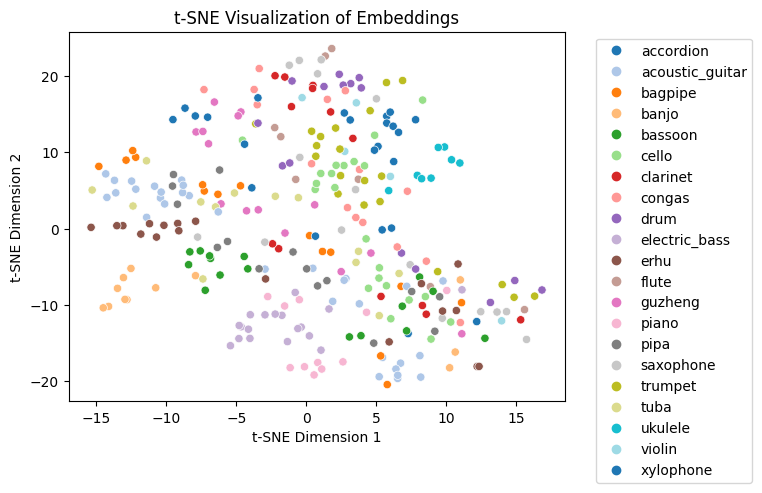

In [14]:
from sklearn.manifold import TSNE

# Function to extract embeddings
def get_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for video, audio, labels in dataloader:
            video = video.to(device)
            audio = [a.to(device) for a in audio]

            z_video, z_audio, _ = model(video, audio)

            embeddings = torch.cat([z_video, z_audio], dim=1)

            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_embeddings), torch.cat(all_labels)

# Get embeddings from validation set
embeddings, labels = get_embeddings(model, val_dataloader, device)

# Get class names from class_to_idx (from previous answer)
index_to_class = {v: k for k, v in val_dataloader.dataset.class_to_idx.items()}
class_names = [index_to_class[label.item()] for label in labels]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

# Create a DataFrame for plotting with Seaborn
df = pd.DataFrame({'t-SNE Dimension 1': embeddings_2d[:, 0],
                   't-SNE Dimension 2': embeddings_2d[:, 1],
                   'Class': class_names})

# Plot with class names
sns.scatterplot(data=df, x='t-SNE Dimension 1', y='t-SNE Dimension 2', hue='Class',
                palette=sns.color_palette("tab20", len(df['Class'].unique())), legend=False)  # Remove default legend

handles = []
unique_classes = sorted(list(set(class_names)))  # Get unique class names
for class_name in unique_classes:
    # Find an example point for each class to get its color/style
    example_idx = class_names.index(class_name)
    handle = plt.Line2D([0], [0], marker='o', color=sns.color_palette("tab20", len(unique_classes))[unique_classes.index(class_name)], linestyle='', label=class_name)
    handles.append(handle)  # Add this handle to the list
plt.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left')  # Custom legend placement

plt.title('t-SNE Visualization of Embeddings')
plt.show()

In [ ]:
# --- Fine-tuning the Classification Head ---

# 1. Freeze feature extractors
for param in model.video_encoder.parameters():
    param.requires_grad = False
for param in model.audio_encoder.parameters():
    param.requires_grad = False

# 2. Adjust optimizer
optimizer_classifier = optim.AdamW(model.classifier.parameters(), lr=1e-3)

# 3. Fine-tuning loop and plotting
num_fine_tune_epochs = 20
fine_tune_losses = []
fine_tune_accuracies = []

for epoch in range(num_fine_tune_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0

    for video, audio, labels in train_dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        optimizer_classifier.zero_grad()
        _, _, logits = model(video, audio)
        classification_loss = F.cross_entropy(logits, labels)

        classification_loss.backward()
        optimizer_classifier.step()

        epoch_loss += classification_loss.item()
        _, predicted = torch.max(logits, 1)
        epoch_total += labels.size(0)
        epoch_correct += (predicted == labels).sum().item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    avg_epoch_accuracy = epoch_correct / epoch_total

    fine_tune_losses.append(avg_epoch_loss)
    fine_tune_accuracies.append(avg_epoch_accuracy)

    print(f"Fine-tuning Epoch [{epoch+1}/{num_fine_tune_epochs}] - Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    # Evaluate on validation set after each fine-tuning epoch
    val_accuracy = evaluate_classification(model, val_dataloader, device)
    fine_tune_accuracies.append(val_accuracy)

print("Fine-tuning finished.")

Fine-tuning Epoch [1/20] - Loss: 3.2087, Accuracy: 0.0721
Validation Accuracy: 0.1618
Fine-tuning Epoch [2/20] - Loss: 2.7427, Accuracy: 0.2275
Validation Accuracy: 0.2621
Fine-tuning Epoch [3/20] - Loss: 2.3570, Accuracy: 0.3509
Validation Accuracy: 0.3074
Fine-tuning Epoch [4/20] - Loss: 2.0501, Accuracy: 0.4882
Validation Accuracy: 0.4531
Fine-tuning Epoch [5/20] - Loss: 1.8394, Accuracy: 0.5576
Validation Accuracy: 0.5728
Fine-tuning Epoch [6/20] - Loss: 1.5782, Accuracy: 0.6796
Validation Accuracy: 0.6343
Fine-tuning Epoch [7/20] - Loss: 1.4346, Accuracy: 0.6949
Validation Accuracy: 0.5858
Fine-tuning Epoch [8/20] - Loss: 1.3038, Accuracy: 0.7503
Validation Accuracy: 0.6796
Fine-tuning Epoch [9/20] - Loss: 1.1988, Accuracy: 0.7767
Validation Accuracy: 0.6117
Fine-tuning Epoch [10/20] - Loss: 1.1522, Accuracy: 0.7517
Validation Accuracy: 0.6634
Fine-tuning Epoch [11/20] - Loss: 1.0290, Accuracy: 0.7906
Validation Accuracy: 0.7540
Fine-tuning Epoch [12/20] - Loss: 0.9967, Accuracy: 

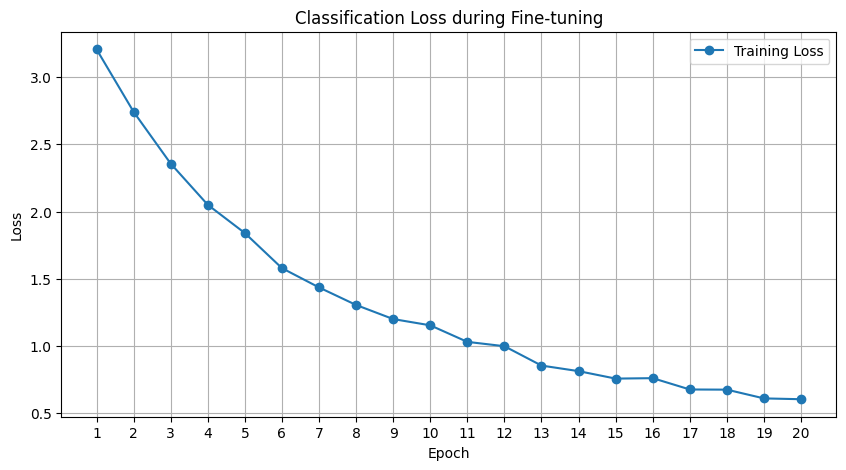

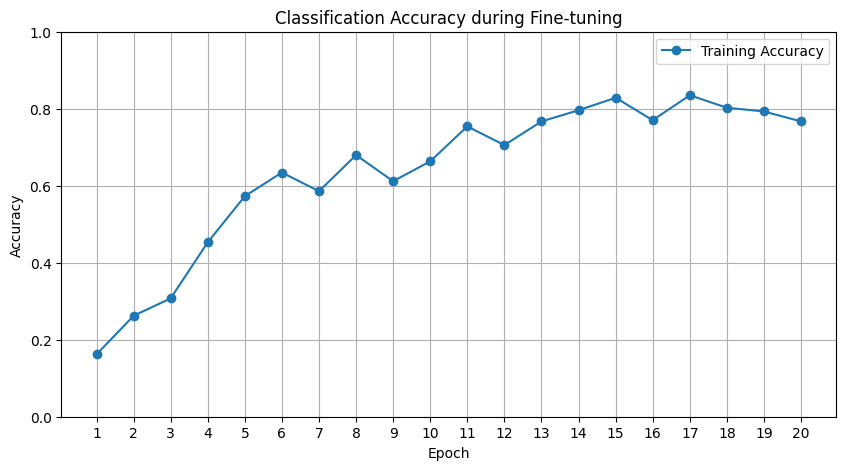

In [ ]:
# --- Plotting ---
import matplotlib.pyplot as plt

epochs_range = range(1, num_fine_tune_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, fine_tune_losses, marker='o', linestyle='-', label='Training Loss')
plt.title('Classification Loss during Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, fine_tune_accuracies[1::2], marker='o', linestyle='-', label='Training Accuracy')
plt.title('Classification Accuracy during Fine-tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '/content/drive/MyDrive/no_contrastive.pth')
print("Model weights saved successfully!")

Model weights saved successfully!


In [14]:
state_dict = torch.load('/content/drive/MyDrive/no_contrastive.pth', map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def per_class_accuracy(model, dataloader, device, num_classes):
    """
    Calculates the per-class accuracy of the model.

    Args:
        model: The trained model.
        dataloader: The DataLoader for the dataset.
        device: The device to run the computation on (e.g., 'cuda' or 'cpu').
        num_classes: The total number of classes in the dataset.

    Returns:
        A list containing the accuracy for each class.
    """

    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for video, audio, labels in dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        _, _, logits = model(video, audio)
        _, predicted = torch.max(logits, 1)

        # Count correct predictions for each class
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == labels[i]:
                class_correct[label] += 1

    # Calculate accuracy for each class
    class_accuracies = [
        class_correct[i] / class_total[i] if class_total[i] else 0
        for i in range(num_classes)
    ]

    return class_accuracies

index_to_class = {v: k for k, v in val_dataloader.dataset.class_to_idx.items()}

# --- Usage ---
class_accuracies = per_class_accuracy(model, val_dataloader, device, num_classes)

# Print per-class accuracies
for i, accuracy in enumerate(class_accuracies):
    class_name = index_to_class[i]  # Get class name from index
    print(f"Class {class_name}: Accuracy = {accuracy:.4f}")

# Calculate average per-class accuracy
avg_per_class_accuracy = sum(class_accuracies) / len(class_accuracies)
print(f"Average Per-Class Accuracy: {avg_per_class_accuracy:.4f}")

Class accordion: Accuracy = 0.8571
Class acoustic_guitar: Accuracy = 0.6250
Class bagpipe: Accuracy = 1.0000
Class banjo: Accuracy = 0.3846
Class bassoon: Accuracy = 0.9231
Class cello: Accuracy = 0.8636
Class clarinet: Accuracy = 0.1250
Class congas: Accuracy = 1.0000
Class drum: Accuracy = 1.0000
Class electric_bass: Accuracy = 1.0000
Class erhu: Accuracy = 0.8000
Class flute: Accuracy = 0.9333
Class guzheng: Accuracy = 0.7143
Class piano: Accuracy = 1.0000
Class pipa: Accuracy = 1.0000
Class saxophone: Accuracy = 0.8000
Class trumpet: Accuracy = 0.5000
Class tuba: Accuracy = 0.8125
Class ukulele: Accuracy = 0.8000
Class violin: Accuracy = 0.8500
Class xylophone: Accuracy = 0.9167
Average Per-Class Accuracy: 0.8050
